In [1]:
packages <- c("sf","dplyr","plyr","ggplot2","mapview","stringr","terra",
              "foreach","aws.s3")

package.check <- lapply(packages, FUN = function(x) {
  suppressPackageStartupMessages(library(x, character.only = TRUE))
})

s3 <- paws::s3()

In [2]:
iso3<-"NGA"

In [3]:
s3_path <- paste("/vsis3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_countries/shp/",iso3,".shp",sep="") #Redo this 

adm <- st_read(s3_path)

adm_prj <- project(vect(adm), "epsg:6933")

Reading layer `NGA' from data source 
  `/vsis3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_countries/shp/NGA.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 94 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 2.671082 ymin: 4.272162 xmax: 14.66994 ymax: 13.88029
Geodetic CRS:  WGS 84


In [4]:
stac_to_terra <- function(catalog_url, ...) {
            # fetch STAC items
            stac <- rstac::stac(catalog_url)
            stac_items <- stac |>
              rstac::stac_search(
                ...
              ) |>
              rstac::get_request()
            
            # replace s3:// prefixes with /vsis3
            stac_items$features <- purrr::map(
                stac_items$features,
                ~ {
                    .x$assets <- purrr::map(
                        .x$assets,
                        ~{
                            .x$href <- gsub("s3://", "/vsis3/", .x$href)
                            .x
                        }
                    )
                .x
                }
            )
        
            item_collection_json_file <- tempfile(fileext=".json")
            item_collection_json <- jsonlite::toJSON(stac_items, auto_unbox=TRUE, pretty=TRUE, digits=10)
            print(item_collection_json)
        
            print(paste("writing item collection to", item_collection_json_file))
            write(item_collection_json, item_collection_json_file)
            
            item_collection_dsn <- glue::glue(
                "STACIT:\"{item_collection_json}\":asset=data",
                item_collection_json=item_collection_json_file
            )
                
            terra::rast(item_collection_dsn)
            }

In [5]:
catalog_url <- "https://stac.maap-project.org"

vect_adm <- vect(adm)

extent <- sf::st_bbox(vect_adm)

In [6]:
#Pull GLAD data
glad_rast_2000 <- stac_to_terra(
   catalog_url = catalog_url,
   bbox = extent,
   collections = "glad-glclu2020-v2",
   datetime = "2000-01-01T00:00:00Z",
            )

{
  "type": "FeatureCollection",
  "context": {
    "limit": 10,
    "returned": 4
  },
  "features": [
    {
      "id": "2000_20N_010E",
      "bbox": [10, 10, 20, 20],
      "type": "Feature",
      "links": [
        {
          "rel": "collection",
          "type": "application/json",
          "href": "https://stac.maap-project.org/collections/glad-glclu2020-v2"
        },
        {
          "rel": "parent",
          "type": "application/json",
          "href": "https://stac.maap-project.org/collections/glad-glclu2020-v2"
        },
        {
          "rel": "root",
          "type": "application/json",
          "href": "https://stac.maap-project.org/"
        },
        {
          "rel": "self",
          "type": "application/geo+json",
          "href": "https://stac.maap-project.org/collections/glad-glclu2020-v2/items/2000_20N_010E"
        }
      ],
      "assets": {
        "data": {
          "href": "/vsis3/nasa-maap-data-store/file-staging/nasa-map/glad-glclu2020/

In [7]:
glad_rast_2000

class       : SpatRaster 
dimensions  : 80000, 80000, 1  (nrow, ncol, nlyr)
resolution  : 0.00025, 0.00025  (x, y)
extent      : 0, 20, 0, 20  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source      : filee94b119155.json:asset=data 
varname     : filee94b119155 
name        : filee94b119155 

In [8]:
colName<- paste0(iso3,"_GLADCover_reclass2000")

In [9]:
colName

[1] "NGA_GLADCover_reclass2000"

In [10]:
r<-glad_rast_2000

reclass_matrix <- matrix(c(
   0,  1,  1, 
   2, 18, 2,
   19, 24, 3,
   25, 32, 4,
   33, 42, 5,
   43, 48, 6,
   49,99, 99,
   100, 101, 7,
   102, 118, 8,
   119, 124, 9,
   125, 132, 10,
   133, 142, 11,
   143, 148, 12,
   149, 199, 99,
   200, 207, 13,
   208, 255, 99
), ncol = 3, byrow = TRUE)

r_reclassified <- classify(r, reclass_matrix)

In [11]:
names(r_reclassified)[1]<-c(colName)

In [12]:
names(r_reclassified[1])

[1] "NGA_GLADCover_reclass2000"

In [13]:
r_reclassified

class       : SpatRaster 
dimensions  : 80000, 80000, 1  (nrow, ncol, nlyr)
resolution  : 0.00025, 0.00025  (x, y)
extent      : 0, 20, 0, 20  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source      : spat_EcGC02JwRRV7ROR_233.tif 
name        : NGA_GLADCover_reclass2000 
min value   :                         0 
max value   :                       200 

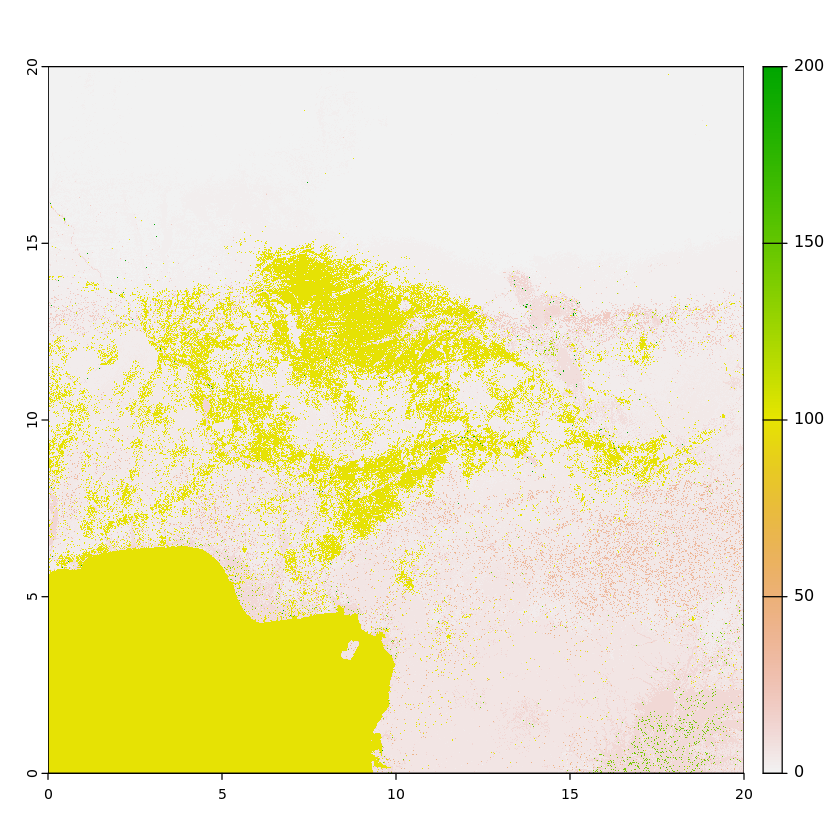

In [14]:
# Plot for visualization
plot(r_reclassified)

In [15]:
filename <- paste("~/my-public-bucket/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/",iso3,"_GLADCover_reclass2000.tif", sep="")

In [16]:
filename

[1] "~/my-public-bucket/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/NGA_GLADCover_reclass2000.tif"

In [17]:
writeRaster(r_reclassified,filename)

Warning message:
“[writeRaster] Estimated disk space needed without compression: 23GB. Available: 3 GB.”
